<span style="font-family: 'Georgia', serif; font-size: 40px; color: #00000;">Demand Orders Prediction</span>


17:16:00 - cmdstanpy - INFO - Chain [1] start processing
17:16:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


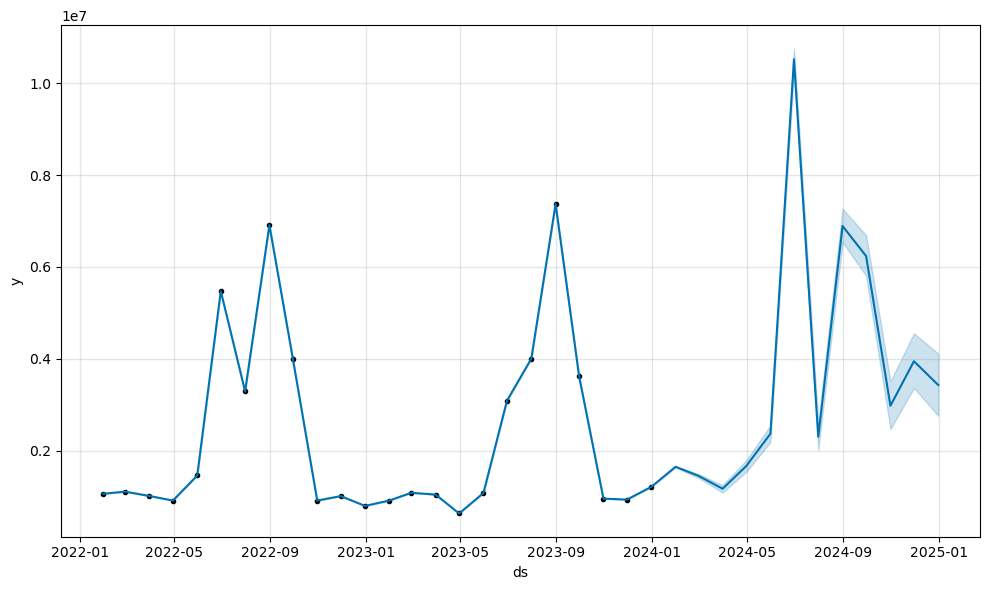

In [1]:
import pandas as pd

# Load your data
df = pd.read_csv('data_cleaned.csv')

df['Date Commande'] = pd.to_datetime(df['Date Commande'])

# Aggregate demand across all articles and resample to monthly
total_demand = df.groupby('Date Commande')['Quantité'].sum()
monthly_demand = total_demand.resample('M').sum()  # 'D' for daily frequency

# Prepare DataFrame for Prophet
ts_df = monthly_demand.reset_index()
ts_df.rename(columns={'Date Commande': 'ds', 'Quantité': 'y'}, inplace=True)

from prophet import Prophet

# Initialize model (adjust seasonalities as needed)
model = Prophet(yearly_seasonality=True) 
model.fit(ts_df)

# Create future dates for the next year
future_dates = model.make_future_dataframe(periods=12, freq='M') 

# Predict and visualize
forecast = model.predict(future_dates)
fig = model.plot(forecast)


In [2]:
import pandas as pd
import plotly.express as px
from prophet import Prophet
from ipywidgets import interact

# Load your data
df = pd.read_csv('data_cleaned.csv')
df['Date Commande'] = pd.to_datetime(df['Date Commande'])

# Create unique product IDs list
unique_product_ids = df['Nom Article'].unique().tolist()

# Function to forecast demand for a specific article
def forecast_demand(product_id):
    product_df = df[(df['Nom Article'] == product_id) & (df['Quantité'] > 0)] 

    if product_df.empty:
        print(f"No sales data found for product '{product_id}'.")
        return

    # Resample to monthly
    ts_df = product_df[['Date Commande', 'Quantité']]
    ts_df.set_index('Date Commande', inplace=True)
    ts_df = ts_df.resample('M').sum() 
    ts_df.rename(columns={'Quantité': 'y'}, inplace=True)
    ts_df.reset_index(inplace=True)
    ts_df.rename(columns={'Date Commande': 'ds'}, inplace=True)

    # Code for External Factors 
    # holidays_df = pd.DataFrame({
    #    'holiday': 'my_holiday', 
    #    'ds': pd.to_datetime(['2023-12-25', '2024-01-01', ...]),  # Add your holidays
    #    'lower_window': 0,  # Days before the holiday with impact
    #    'upper_window': 2   # Days after the holiday with impact
    # })
    
    model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5,
    holidays_prior_scale=0.5
) # Adjust seasonality as needed
    model.fit(ts_df)

    future_dates = model.make_future_dataframe(periods=12, freq='M') 
    forecast = model.predict(future_dates)

    # Ensure predictions are non-negative
    forecast[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']].clip(lower=0)

    return forecast

# Interactive visualization
def visualize_forecast(product_id):
    forecast = forecast_demand(product_id)
    if forecast is not None:  # Check if forecast was generated successfully
        fig = px.line(forecast, x='ds', y='yhat', title=f'Demand Forecast for Product: {product_id}')
        fig.update_layout(showlegend=False) 
        fig.show()

interact(visualize_forecast, product_id=unique_product_ids)



interactive(children=(Dropdown(description='product_id', options=('BLOC EPHEMERIDE BLANC REF:550050', 'MACHINE…

<function __main__.visualize_forecast(product_id)>

In [3]:

# ! add this for better accuracy 

# Example regressor data
#df['promotion'] = ...  # Add your promotional data
#df['weather'] = ...    # Add weather data
#df['economic_indicator'] = ...  # Add economic indicators

#from prophet import Prophet

# Create and fit the model
#model = Prophet(yearly_seasonality=True)
#model.add_regressor('promotion')
#model.add_regressor('weather')
#model.add_regressor('economic_indicator')

# Fit the model
#model.fit(df[['ds', 'y', 'promotion', 'weather', 'economic_indicator']])
